In [1]:
import os
import gc
from tqdm import tqdm
import pickle
import librosa

import torch
import torch.nn as nn
import numpy as np

import s3prl.hub as hub

import soundfile as sf
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from scipy.signal import butter, filtfilt
from scipy.stats.stats import pearsonr

C:\Users\tejas\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\tejas\AppData\Local\Temp\ipykernel_26520\609860635.py:20: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [19]:
def get_files_recur(files_path, ext):
    files = []
    for root, _, filenames in os.walk(files_path):
        files.extend([os.path.join(root, f) for f in filenames if f.endswith(ext)])
    return files

In [200]:
class EMADataset():

    def __init__(
            self, 
            model, 
            data_path, 
            ema_path="ema\\",
            save_features=False, 
            five_min_train=False,
            train_ratio=0.8,
            layer=9, 
            device=0):
        self.data_path = data_path
        self.device = device

        self.sr = 16000

        #for root, _, filenames in os.walk(self.wav_path):
        #    print(filenames)
        #    self.wav_names = [Path(f).stem for f in filenames if f.endswith(".wav")]
        #    self.wavs = [librosa.load(f"{self.wav_path}/{f}", sr=sr)[0] for f in filenames if f.endswith(".wav")]
            
        #for _, _, filenames in os.walk(self.ema_path):
        #    self.ema_names = [Path(f).stem for f in filenames if f.endswith(".npy")]
        
        print("Getting wav files")
        self.wav_files = get_files_recur(self.data_path, '.wav')
        self.wav_names = [Path(f).stem for f in tqdm(self.wav_files)]
        print("Done")

        print("Getting EMA files")
        self.ema_files = get_files_recur(self.data_path, '.npy')
        self.ema_files = [f for f in self.ema_files if ema_path in f]
        self.ema_names = [Path(f).stem for f in self.ema_files if f.endswith('.npy') and ema_path in f]
        print("Done")
        
        self.valid_files = list(set(self.wav_names) & set(self.ema_names))

        #self.emas = np.concatenate([np.load(f"{self.ema_path}/{f}.npy") for f in self.valid_files], axis=0)
        
        if save_features:
            print("Saving speech features")
            self.save_wavlm_features(model, layer)

        #self.feats = np.concatenate([np.load(f"{self.feat_dir}/{f}.npy") for f in self.valid_files], axis=0)

        feats = []
        emas = []
        trg_sr = 50
        ema_sr = 200
        ft_sr = 50

        for file in tqdm(self.ema_files):
            ema_cut_len = len(ema_path) - 1 if '\\' in ema_path else len(ema_path)
            feat = np.load(f"{os.path.dirname(file)[:-ema_cut_len]}/feat_hb/{Path(file).stem}.npy")
            ema = np.load(file)

            if trg_sr < ema_sr:
                target = EMADataset.downsample_by_mean(ema, int(ema_sr/trg_sr))
            else:
                target = ema

            if trg_sr < ft_sr:
                feature = EMADataset.downsample_by_mean(feat, int(ft_sr/trg_sr))
            elif trg_sr > ft_sr:
                feature = EMADataset.upsample(feat, int(trg_sr/ft_sr))
            else:
                feature = feat

            data_len = min(target.shape[0], feature.shape[0])
            target = target[:data_len]
            feature = EMADataset.butter_bandpass_filter(feature, 6, 50)
            feature = feature[:data_len]

            feats.append(feature)
            emas.append(target)
        
        self.feats = np.concatenate(feats, 0)
        self.emas = np.concatenate(emas, 0)

        print(f"Total feats shape: {self.feats.shape}")
        print(f"Total emas shape: {self.emas.shape}")

        #feature = (feature - feature.mean()) / feature.std()
        #target = (target - target.mean()) / target.std()

        train_len = int(self.emas.shape[0] * train_ratio)
        if five_min_train:
            train_len = trg_sr * 5 * 60
        self.feat_train, self.feat_test = self.feats[0:train_len], self.feats[train_len:]
        self.ema_train, self.ema_test = self.emas[0:train_len], self.emas[train_len:]

        print(f"Train Length: {self.feat_train.shape[0]}")
        print(f"Test Length: {self.feat_test.shape[0]}")
    
    def set_train_ratio(self, train_ratio):
        train_len = int(self.emas.shape[0] * train_ratio)
        self.feat_train, self.feat_test = self.feats[0:train_len], self.feats[train_len:]
        self.ema_train, self.ema_test = self.emas[0:train_len], self.emas[train_len:]

    def save_wavlm_features(self, model, layer):
        self.wavs = [librosa.load(f, sr=self.sr)[0] for f in tqdm(self.wav_files)]
        for i in tqdm(range(len(self.wavs))):
            if os.path.exists(f"{os.path.dirname(self.wav_files[i])[:-4]}/feat_hb/{self.wav_names[i]}.npy"):
                continue
            wav = torch.from_numpy(self.wavs[i]).to(self.device)
            sample_emb = model([wav])["hidden_states"][layer]
            sample_emb = sample_emb.squeeze(0)

            np.save(f"{os.path.dirname(self.wav_files[i])[:-4]}/feat_hb/{self.wav_names[i]}.npy", sample_emb.detach().cpu())

    def downsample_by_mean(arr, factor):
        # arr : T,d
        T, d = arr.shape
        arr = arr[:int(T//factor*factor)]
        arr = arr.reshape(T//factor,factor, d)
        arr = arr.mean(1)
        return arr

    def upsample(arr,factor):
        # arr: T,d
        T, d = arr.shape
        output = np.zeros((T*factor,d))
        arr = np.concatenate([arr, arr[-1:]],0)
        for f in range(factor):
            output[np.arange(T)*factor+f] = (1-f/factor)*arr[:-1] + (f/factor)*arr[1:]
        return output

    def butter_bandpass(cut, fs, order=5):

        if isinstance(cut,list) and len(cut) == 2:
            return butter(order, cut, fs=fs, btype='bandpass')
        else:
            return butter(order, cut, fs=fs, btype='low')

    def butter_bandpass_filter(data, cut, fs, order=5):
        b, a = EMADataset.butter_bandpass(cut, fs, order=order)
        y = filtfilt(b, a, data,axis=0)
        return y

In [30]:
device = 0
model_name = "hubert_large_ll60k"
wavlm_model = getattr(hub, model_name)()

wavlm_model = wavlm_model.to(device)

In [388]:
mngu0_path = "../../../mngu0/"

mng_npy_path = mngu0_path + "nema_npy/"
mng_wav_path = mngu0_path + "wav/"
mng_feat_path = mngu0_path + "feat_hb/"

hprc_path = "../../../HPRC/"

hprc_npy_path = hprc_path + "ema_scaled/"
hprc_wav_path = hprc_path + "wav/"
hprc_feat_path = hprc_path + "feat_hb/"

ll_path = "../../../language_learning/"

ll_nature_path = ll_path + "nature/"
ll_vowels_path = ll_path + "vowels/"

In [95]:
ema_dataset = EMADataset(
    model=wavlm_model, 
    data_path=hprc_path + "M01/", 
    save_features=False, 
    five_min_train=True,
    layer=9)

Getting wav files


100%|██████████| 1553/1553 [00:00<00:00, 129487.80it/s]


Done
Getting EMA files
Done


  0%|          | 0/1553 [00:00<?, ?it/s]

100%|██████████| 1553/1553 [00:08<00:00, 176.79it/s]


Total feats shape: (83333, 1024)
Total emas shape: (83333, 12)
Train Length: 15000
Test Length: 68333


In [389]:
#sample_name = "M01_B01_S13_R01_N"
#sample_name = "mngu0_s1_0001"
#sample_name = "china_audio"
#sample_name = "spanish_audio"
sample_name = "short_vowels"
audio, sr = librosa.load(f"{ll_vowels_path}/{sample_name}.wav", sr=16000)
#audio = audio[160000:320000]
#sf.write("wav/_audio.wav", audio, samplerate=16000)
audio = torch.from_numpy(audio).to(device)
print(f"Sample {sample_name} imported with shape={audio.shape} and sr={sr}.")

Sample short_vowels imported with shape=torch.Size([152235]) and sr=16000.


In [390]:
layer = 9
#print(wavlm_model([audio])["hidden_states"][0].shape[1])
sample_emb = wavlm_model([audio])["hidden_states"][layer]
sample_emb = sample_emb.squeeze(0)
print(f"Sample {sample_name} converted to WavLM embeddings (layer {layer + 1}) with shape {sample_emb.shape}.")

Sample short_vowels converted to WavLM embeddings (layer 10) with shape torch.Size([475, 1024]).


In [30]:
del sample_emb
gc.collect()
torch.cuda.empty_cache()

In [71]:
#sample_ema = torch.from_numpy(np.load(f"{mng_npy_path}/{sample_name}.npy", allow_pickle=True))
sample_ema = torch.from_numpy(np.load(f"{ll_nature_path}/spanish_inverted.npy", allow_pickle=True))
sample_ema = sample_ema
sample_ema = EMADataset.downsample_by_mean(sample_ema, int(100/50))
print(f"Sample {sample_name} EMA imported with shape={sample_ema.shape}.")

Sample spanish_audio EMA imported with shape=torch.Size([899, 12]).


In [361]:
lr_model = LinearRegression()
lr_model.fit(ema_dataset.feat_train, ema_dataset.ema_train)

#with open('ckpts/lr_wlm_l20_mng5m.pkl', 'rb') as f:
#    lr_model = pickle.load(f)

with open('ckpts/lr_hb_l10_mng_8.pkl','wb') as f:
    pickle.dump(lr_model, f)

(475, 12)


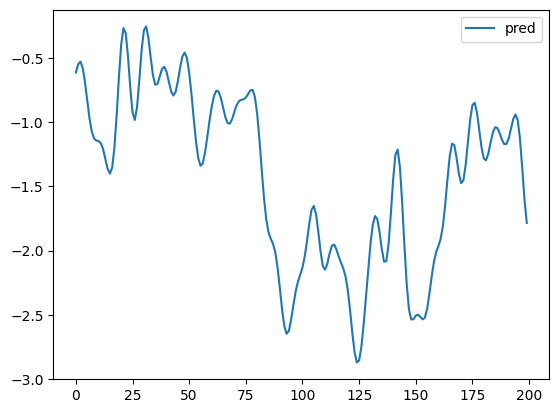

In [391]:
#vis_ema = ema_dataset.ema_train
#vis_feat = ema_dataset.feat_train
#vis_feat = EMADataset.butter_bandpass_filter(vis_feat, 6, 50)

vis_feat = sample_emb.detach().cpu()
vis_feat = EMADataset.butter_bandpass_filter(vis_feat, 6, 50)
#vis_ema = sample_ema.detach().cpu()

target_pred = lr_model.predict(vis_feat)
print(target_pred.shape)

start = 0
end = 200
feat_num = 11

#plt.plot(vis_ema[start:end, feat_num], label="gt")
plt.plot(target_pred[start:end, feat_num], label="pred")
plt.legend()

#print(pearsonr(target_pred[:, feat_num], vis_ema[:, feat_num])[0])

In [392]:
#np.save("ema/spanish_gt.npy", vis_ema.detach().cpu().numpy())
convert_to_hprc_order(target_pred)
np.save("ema/short_vowels_pred_hb_mng.npy", target_pred)

In [192]:
target_pred.shape

(317, 12)

In [27]:
def get_corr(prd, trg, feat_num):
    return pearsonr(prd[:, feat_num], trg[:, feat_num])

get_corr(target_pred, ema_dataset.ema_test)

array([-0.04456701, -0.00164   ,  0.04303238, -0.1514373 ,  0.04424047,
        0.05992779, -0.0461335 ,  0.01809644, -0.01538321, -0.078977  ,
        0.060375  , -0.07137544])

In [201]:
corrs = []
ema_dataset = EMADataset(
    model=wavlm_model, 
    data_path=mngu0_path, 
    ema_path="nema_npy\\",
    save_features=False, 
    five_min_train=False,
    layer=9
    )
hprc_dataset = EMADataset(
    model=wavlm_model, 
    data_path=hprc_path + "M01/", 
    ema_path="ema_scaled",
    save_features=False, 
    five_min_train=False,
    layer=9
    )

Getting wav files


100%|██████████| 1354/1354 [00:00<00:00, 168769.32it/s]


Done
Getting EMA files
Done


100%|██████████| 1189/1189 [00:10<00:00, 108.54it/s]


Total feats shape: (224137, 1024)
Total emas shape: (224137, 12)
Train Length: 179309
Test Length: 44828
Getting wav files


100%|██████████| 1553/1553 [00:00<00:00, 81668.98it/s]


Done
Getting EMA files
Done


100%|██████████| 1553/1553 [00:10<00:00, 147.20it/s]


Total feats shape: (83333, 1024)
Total emas shape: (83333, 12)
Train Length: 66666
Test Length: 16667


In [360]:
feat_corrs = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
    7: [],
    8: [],
    9: [],
    10: [],
    11: []
}

HPRC_channel_label = ['LIX','LIY','ULX','ULY','LLX','LLY','TTX','TTY','TBX','TBY','TDX','TDY']

for i in range(1, 10):
    ratio = i / 10.

    ema_dataset.set_train_ratio(ratio)
    print(ema_dataset.ema_train.shape[0])
    lr_model = LinearRegression()
    lr_model.fit(ema_dataset.feat_train, ema_dataset.ema_train)

    vis_ema = ema_dataset.ema_test
    vis_feat = ema_dataset.feat_test
    target_pred = lr_model.predict(vis_feat)
    for feat_num in range(12):
        corr = pearsonr(target_pred[:, feat_num], vis_ema[:, feat_num])[0]
        print(corr)
        feat_corrs[feat_num].append(corr)

22413


KeyboardInterrupt: 

In [118]:
list(feat_corrs.keys())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [160]:
list(feat_corrs.values())

[[0.3352705677891768,
  0.30076754988716303,
  0.2987969850998197,
  0.2953943006806014,
  0.2961438771611969,
  0.2959716330837283,
  0.27671156743381436,
  0.26130719295910887,
  0.27884705477956206],
 [0.2462023788738963,
  0.19087824638713738,
  0.16565825506125853,
  0.14493900980599672,
  0.14574562602617144,
  0.14536675012452038,
  0.14201036117378568,
  0.13964909009051626,
  0.15278423609709038],
 [0.22855728318260474,
  0.1846283717504207,
  0.17615062017038924,
  0.17231082047505505,
  0.1643257697607423,
  0.14814067859501037,
  0.12547709431494394,
  0.12038321161676432,
  0.0823602492188006],
 [0.1858797672809386,
  0.14410642388403908,
  0.12947822370346382,
  0.13352932087710934,
  0.12947607406248546,
  0.1185385839725411,
  0.11204053442973166,
  0.11846708831895593,
  0.07712039306994349],
 [0.21953650713455558,
  0.1812357499987258,
  0.176071679088337,
  0.17459338996790913,
  0.17664989582655713,
  0.17382589236567159,
  0.15149302491347155,
  0.13782934031689908

Text(0.5, 1.0, 'Linear Map Corrs for MNGU0 Ratios (nema_npy)')

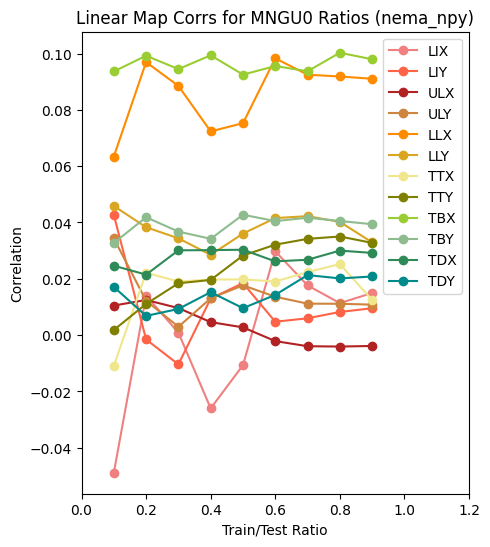

In [203]:
colors = ['lightcoral', 'tomato', 'firebrick', 'peru', 'darkorange', 'goldenrod', 'khaki', 'olive', 'yellowgreen', 'darkseagreen', 'seagreen', 'darkcyan']
plt.figure(figsize=(5, 6))
for i in range(12):
    plt.plot([i / 10. for i in range(1, 10)], feat_corrs[i], label=HPRC_channel_label[i], color=colors[i], marker='o')
plt.legend(loc="upper right")
plt.xlim([0, 1.2])
#plt.ylim([0, 1.0])
plt.xlabel("Train/Test Ratio")
plt.ylabel("Correlation")
plt.title("Linear Map Corrs for MNGU0 Ratios (nema_npy)")

In [383]:
mng_08_gt = np.load("../../../language_learning/mngu0_s1_0008.npy")
mng_08_gt = EMADataset.downsample_by_mean(mng_08_gt, int(100/50))

gt_td = mng_08_gt[:, 0:2]

gt_tb = mng_08_gt[:, 2:4]

gt_tt = mng_08_gt[:, 4:6]

gt_li = mng_08_gt[:, 6:8] # locked

gt_ul = mng_08_gt[:, 8:10] # locked

gt_ll = mng_08_gt[:, 10:12] # locked

mng_08_gt[:, 0] = gt_li[:, 0] * -1
mng_08_gt[:, 1] = gt_li[:, 1]
mng_08_gt[:, 2] = gt_ul[:, 0] * -1
mng_08_gt[:, 3] = gt_ul[:, 1]
mng_08_gt[:, 4] = gt_ll[:, 0] * -1
mng_08_gt[:, 5] = gt_ll[:, 1]
mng_08_gt[:, 6] = gt_tt[:, 0] * -1
mng_08_gt[:, 7] = gt_tt[:, 1]
mng_08_gt[:, 8] = gt_tb[:, 0] * -1
mng_08_gt[:, 9] = gt_tb[:, 1]
mng_08_gt[:, 10] = gt_td[:, 0] * -1
mng_08_gt[:, 11] = gt_td[:, 1]


np.save("../../../language_learning/mng_08_gtorder.npy", mng_08_gt)

mng_08_tf = np.load("../../../language_learning/mngu0_s1_0008_inverted.npy")

In [380]:
for i in range(12):
    print(i, pearsonr(mng_08_gt[:, i], mng_08_tf[:, i]))

0 PearsonRResult(statistic=0.8303378562127812, pvalue=1.2318846199799065e-162)
1 PearsonRResult(statistic=0.8558442018764547, pvalue=4.157497963037802e-183)
2 PearsonRResult(statistic=0.8512255115059869, pvalue=4.048065279834739e-179)
3 PearsonRResult(statistic=0.81632378677979, pvalue=8.60994382507721e-153)
4 PearsonRResult(statistic=0.80320612611284, pvalue=2.595390064788554e-144)
5 PearsonRResult(statistic=0.8397266497320102, pvalue=9.44504604719885e-170)
6 PearsonRResult(statistic=-0.08692601591850108, pvalue=0.028628409373665866)
7 PearsonRResult(statistic=0.43815101685428715, pvalue=4.008315986450045e-31)
8 PearsonRResult(statistic=-0.061549117677668186, pvalue=0.12157970470983824)
9 PearsonRResult(statistic=0.06844186910455356, pvalue=0.08508021188418766)
10 PearsonRResult(statistic=-0.3331543433165494, pvalue=6.724502340788613e-18)
11 PearsonRResult(statistic=0.08290892401652572, pvalue=0.03688199100762247)


Text(0.5, 1.0, 'GT vs Transformer, 0th feature')

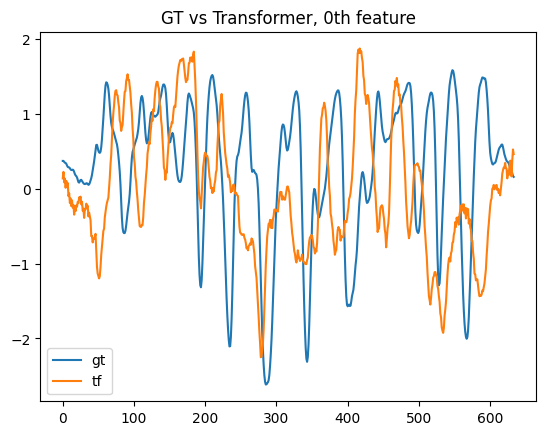

In [381]:
feat_num = 11
plt.plot(mng_08_gt[:, feat_num], label="gt")
plt.plot(mng_08_tf[:, feat_num], label="tf")
plt.legend()
plt.title("GT vs Transformer, 0th feature")

## MNGU0 Order

UL: 0:2

LL: 2:4

LI: 4:6

TT: 6:8

TB: 8:10

TD: 10:12

In [234]:
pearsonr(mng_08_gt[:, 7], mng_08_tf[:, 0])

PearsonRResult(statistic=0.707959616866341, pvalue=1.5617177728563817e-97)

In [382]:
def convert_to_hprc_order(arr):
    arr_td = arr[:, 0:2]

    arr_tb = arr[:, 2:4]

    arr_tt = arr[:, 4:6]

    arr_li = arr[:, 6:8] # locked

    arr_ul = arr[:, 8:10] # locked

    arr_ll = arr[:, 10:12] # locked

    arr[:, 0] = arr_li[:, 0] * -1
    arr[:, 1] = arr_li[:, 1]
    arr[:, 2] = arr_ul[:, 0] * -1
    arr[:, 3] = arr_ul[:, 1]
    arr[:, 4] = arr_ll[:, 0] * -1
    arr[:, 5] = arr_ll[:, 1]
    arr[:, 6] = arr_tt[:, 0] * -1
    arr[:, 7] = arr_tt[:, 1]
    arr[:, 8] = arr_tb[:, 0] * -1
    arr[:, 9] = arr_tb[:, 1]
    arr[:, 10] = arr_td[:, 0] * -1
    arr[:, 11] = arr_td[:, 1]